In [1]:
import io
from datetime import datetime
from PIL import Image

import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas.core.frame import DataFrame

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DateType

from IPython.display import display

## Db connection
***

In [2]:
spark = (
    SparkSession.builder
    .appName('SSession')
    .master('local[*]')
    .config("spark.driver.memory", "2g") 
    # .config("spark.executor.memory", "2g")
    # .config("spark.executor.cores","2")
    # .config("spark.executor.nums","4")
    .getOrCreate()
)
spark.sparkContext.setLogLevel('OFF')

spark

23/11/24 18:29:12 WARN Utils: Your hostname, shazy-latitude resolves to a loopback address: 127.0.1.1; using 192.168.1.76 instead (on interface wlan0)
23/11/24 18:29:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/24 18:29:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_ord = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "table_name") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

In [4]:
df_prod = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "table_name") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

In [5]:
df_buy = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "table_name") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

Не указываем `'org.postgresql.Driver'` т.к. в корень спарка `jars` добавили JDBC postgresql driver `ver-42.6.0` напрямую

***

In [6]:
def spark_shape(self):
    # ф-ция заменитель .shape`
    return (self.count(), len(self.columns))

pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [7]:
def info_spark_df(df):
    # first look
    df.printSchema()
    print(f'Data size: {df.shape()[0]} row(s), {df.shape()[1]} column(s)')
    df.describe().show(vertical=True)

# Таблица orders

In [8]:
info_spark_df(df_ord)

root
 |-- id: integer (nullable = true)
 |-- buyers_id: integer (nullable = true)
 |-- item_ids: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- time: timestamp (nullable = true)



Data size: 5480686 row(s), 4 column(s)


-RECORD 0-----------------------
 summary   | count              
 id        | 5480686            
 buyers_id | 5480686            
-RECORD 1-----------------------
 summary   | mean               
 id        | 2767965.005923346  
 buyers_id | 504855.8168667207  
-RECORD 2-----------------------
 summary   | stddev             
 id        | 1596593.4488654672 
 buyers_id | 292033.7576792665  
-RECORD 3-----------------------
 summary   | min                
 id        | 1                  
 buyers_id | 1                  
-RECORD 4-----------------------
 summary   | max                
 id        | 5532614            
 buyers_id | 1010547            



In [9]:
df_ord.select('time').limit(5).show()

+--------------------+
|                time|
+--------------------+
|2018-02-18 00:06:...|
|2019-01-26 19:14:...|
|2018-07-09 07:19:...|
|2017-10-01 15:36:...|
|2022-04-10 10:35:...|
+--------------------+



## Поработаем со столбцом item_ids

In [10]:
null_check_udf = f.udf(lambda arr: arr is None or any(x is None for x in arr))
df_ord.withColumn("has_null_array", null_check_udf(f.col("item_ids"))).filter(f.col("has_null_array") == True).count()

0

замечательно, это означает, что у нас нету пустых значений в столбце `item_ids`.

In [11]:
df_ord \
.withColumn('len_items', f.size('item_ids')).select('len_items').describe().show()

+-------+------------------+
|summary|         len_items|
+-------+------------------+
|  count|           5480686|
|   mean|12.999412117388225|
| stddev| 7.211086687579796|
|    min|                 1|
|    max|                25|
+-------+------------------+



Будем иметь ввиду:
* в среднем покупают по ~13 смартфонов;
* Минимальное кол-во смартфонов при покупке - 1
* Максимальное - 25

In [12]:
items_df = df_ord.select('item_ids')
items_df.select(f.explode("item_ids").alias("value")).groupBy("value").count().orderBy('count', ascending=False).show()

+-----+-----+
|value|count|
+-----+-----+
| 1791|31359|
|   45|31355|
|  150|31351|
|  534|31348|
| 1522|31329|
|  262|31327|
| 1459|31288|
| 2061|31283|
|  363|31274|
| 1302|31272|
| 1844|31268|
|  193|31267|
| 1373|31265|
|  320|31264|
| 1850|31262|
| 2189|31260|
| 1343|31258|
| 2159|31257|
| 1217|31254|
|  969|31252|
+-----+-----+
only showing top 20 rows



Исходя из полученной информации топ продаж  `45`, `150`, `1791` модели.

### Щупаем дату

In [13]:
# Фильтрация строк в определенный день
target_date = "2021-02-21"
tar_df = df_ord.filter(f.col("time").cast("date") == target_date)

tar_df.show()

+------+---------+--------------------+--------------------+
|    id|buyers_id|            item_ids|                time|
+------+---------+--------------------+--------------------+
|603048|   941596|[1610, 1017, 1297...|2021-02-21 06:55:...|
|603277|   892384|    [839, 777, 1605]|2021-02-21 00:59:...|
|604568|   900110|[930, 1389, 662, ...|2021-02-21 07:13:...|
|610909|   355815|[562, 1153, 559, ...|2021-02-21 02:39:...|
|612201|   674336|[634, 2309, 238, ...|2021-02-21 05:17:...|
|616163|   139034|[908, 2096, 135, ...|2021-02-21 21:05:...|
|624669|   217888|[2147, 1339, 2271...|2021-02-21 04:56:...|
|626084|   443740|[2083, 1427, 1897...|2021-02-21 21:41:...|
|628409|   458525|[860, 1872, 150, ...|2021-02-21 10:19:...|
|629263|   264962|[48, 140, 956, 74...|2021-02-21 06:52:...|
|630405|   204144|  [1300, 1571, 1996]|2021-02-21 17:18:...|
|631436|   400157|[1215, 804, 1905,...|2021-02-21 05:39:...|
|637284|   425617|[2064, 2196, 1150...|2021-02-21 16:40:...|
|637327|   527858|[458, 

In [14]:
# Фильтрация строк в заданном временном промежутке
start_date = "2021-02-21"
end_date = "2022-01-11"
df_filtered = df_ord.filter((f.col("time") >= start_date) & (f.col("time") <= end_date))

df_filtered.show()

+------+---------+--------------------+--------------------+
|    id|buyers_id|            item_ids|                time|
+------+---------+--------------------+--------------------+
|600004|   136193|[48, 814, 717, 16...|2021-11-15 04:59:...|
|600006|   758956|[778, 1810, 1204,...|2021-02-26 21:07:...|
|600013|   967263|[242, 1280, 1660,...|2021-11-23 19:16:...|
|600036|   439473|[200, 136, 1678, ...|2022-01-01 07:17:...|
|600039|   451513|[214, 2080, 577, ...|2021-05-12 17:47:...|
|600044|    73630|[1744, 841, 47, 1...|2021-05-28 09:20:...|
|600048|   278423|[1231, 1197, 711,...|2021-07-19 22:05:...|
|600052|   541970|[1691, 903, 539, ...|2021-03-07 20:18:...|
|600061|   127901|[1989, 244, 780, ...|2021-05-14 13:32:...|
|600062|   605973|[635, 692, 284, 1...|2021-12-20 17:34:...|
|600076|   344724|[1032, 808, 1991,...|2021-02-26 10:12:...|
|600080|   410318|[1076, 1889, 857,...|2021-10-22 11:17:...|
|600095|   605383|[800, 1478, 168, ...|2021-08-03 13:00:...|
|600100|   938433|[235, 

### Расскрываем array и смотрим на метрики

In [15]:
data = df_ord.withColumn("item_id", f.explode(df_ord["item_ids"])).drop('item_ids')

df_prod = df_prod.withColumnRenamed("id", "prod_id")
data = data.join(df_prod, data.item_id == df_prod.prod_id, "left").drop('prod_id')

In [16]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- buyers_id: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- series: string (nullable = true)
 |-- memory: string (nullable = true)
 |-- price: float (nullable = true)



In [17]:
data.select('time', 'item_id', 'price').limit(5).show()

+--------------------+-------+--------+
|                time|item_id|   price|
+--------------------+-------+--------+
|2018-02-18 00:06:...|    816|  8699.0|
|2018-02-18 00:06:...|   1153| 95990.0|
|2018-02-18 00:06:...|   2028| 16990.0|
|2018-02-18 00:06:...|   1691|160990.0|
|2018-02-18 00:06:...|   2140| 82690.0|
+--------------------+-------+--------+



In [18]:
sales_metrics = data.repartition(f.year("time")).groupBy(f.year("time").alias("year")) \
                    .count() \
                    .orderBy("year")

In [19]:
window = Window.orderBy('year')
sales_metrics.withColumn("cumsum", f.sum("count").over(window)).show()

+----+--------+--------+
|year|   count|  cumsum|
+----+--------+--------+
|2017|11860010|11860010|
|2018|11870902|23730912|
|2019|11873002|35603914|
|2020|11915283|47519197|
|2021|11863358|59382555|
|2022|11863141|71245696|
+----+--------+--------+



Исходя из полученных результатов:
* Каждый год на протяжении 6 лет продавалось по ~12млн. единиц техники;
* За 5 лет было продано ~71.2 млн. смартфонов.

## Data metric

In [20]:
def count_models_boxplot(df: DataFrame) -> None:
    models_top = df.groupby('item_id').count()\
          .join(df_prod, df.item_id == df_prod.prod_id, "left")\
          .drop('prod_id').orderBy('count', ascending=False)\
          .select('item_id', 'count').toPandas()
    mean_value = models_top['count'].mean()
    
    
    plt.figure(figsize=(7,7))
    ax = sns.boxplot(models_top['count'], showmeans=True)
    ax = sns.stripplot(models_top['count'], color='orange', jitter=0.3, size=2.5)
    ax.legend([ax.lines[-2]], [f'Mean count: {mean_value:.2f}'])
    plt.xlabel('')
    plt.ylabel('count')
    plt.title(f'Разброс кол-ва проданных моделей {target_date}', fontsize=15)
    plt.show()

In [21]:
def buyers_revenue_boxplot(df: DataFrame) -> None:
    buyers_top = df.groupby('buyers_id').agg(f.sum('price').alias('revenue')).toPandas()
    mean_value = buyers_top['revenue'].mean()
    
    plt.figure(figsize=(7,7))
    ax = sns.boxplot(buyers_top['revenue'], showmeans=True)
    ax.legend([ax.lines[-2]], [f'Mean revenue: {mean_value:.2f}'])
    plt.xlabel('')
    plt.ylabel('revenue')
    plt.title(f'Разброс выручки с каждого пользователя {target_date}', fontsize=15)
    plt.show()

In [22]:
def get_map_top_buyers(df: DataFrame, file_name: str) -> None:
    df = df.groupby('buyers_id').agg(f.sum('price').alias('revenue'))\
           .orderBy('revenue', ascending=False)\
           .select('buyers_id', f.format_number('revenue', 2).alias('revenue')) \
           .join(df_buy, df.buyers_id == df_buy.id, 'left') \
           .select('buyers_id', 'geo_lat', 'geo_lon', 'revenue', 'place', 'region').toPandas()

    # Максимальное кол-во отображенных маркеров для моей системы 30к, поэтому я ставлю ограничение меньше этого числа 
    if len(df) > 20_000:
        df = df[:20_000]
    
    map_osm = folium.Map()
    marker_cluster = MarkerCluster().add_to(map_osm)
    
    for indice, row in df.iterrows():
        folium.Marker(
            location=[row["geo_lat"], row["geo_lon"]],
            popup=f"<strong>{row['place']} {row['region']} Revenue:{row['revenue']}</strong>",
        ).add_to(marker_cluster)
    map_osm.save("map1.html")

    img_data = map_osm._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    img.save(f'./data/{file_name}.png')

    display(map_osm)

### Daily metric

In [23]:
# Выборка в опр. день
target_date = "2021-02-21"
tar_df = data.filter(f.col("time").cast("date") == target_date)

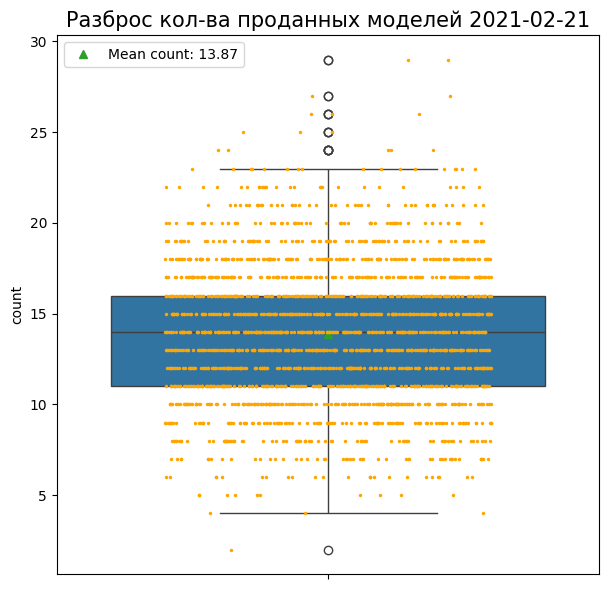

In [24]:
count_models_boxplot(tar_df)

In [25]:
# Дневная выручка
tar_df.select(f.sum(f.col('price')).alias('revenue'))\
      .select(f.format_number('revenue', 2).alias('revenue'))\
      .show()

+----------------+
|         revenue|
+----------------+
|2,221,062,261.00|
+----------------+



In [26]:
# Топ 5 покупателей за определенный день
tar_df.groupby('buyers_id').agg(f.sum('price').alias('revenue'))\
      .orderBy('revenue', ascending=False)\
      .select('buyers_id', f.format_number('revenue', 2).alias('revenue')).limit(5).show()

+---------+------------+
|buyers_id|     revenue|
+---------+------------+
|   474330|3,948,546.00|
|   980205|2,339,005.00|
|   912399|2,323,841.00|
|   802646|2,302,831.00|
|   570926|2,297,849.00|
+---------+------------+



In [ ]:
get_map_top_buyers(tar_df, "day_map")

### Вывод работы ф-ции get_map_top_buyers(tar_df, "day_map"):

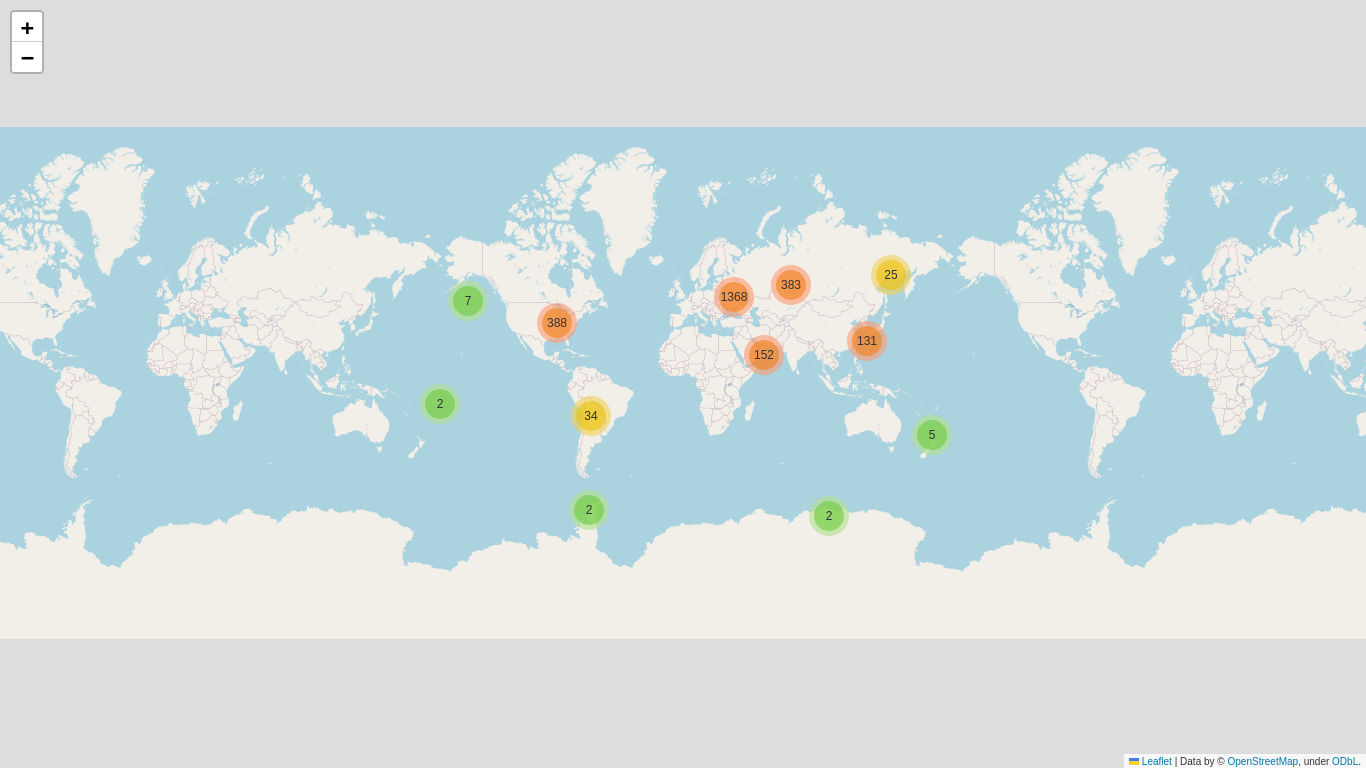

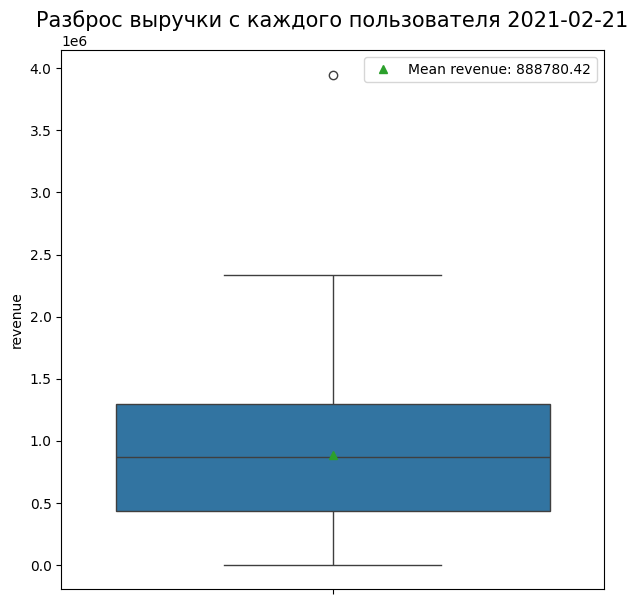

In [28]:
buyers_revenue_boxplot(tar_df)

In [29]:
# Кол-во уникальных пользователей за день
tar_df.select(f.format_number(f.countDistinct(f.col('buyers_id')), 2).alias("unique_users_count")).show()

+------------------+
|unique_users_count|
+------------------+
|          2,499.00|
+------------------+



### Month metric

In [30]:
target_date = "2018-02"

tar_df = data.filter(f.date_format(f.col("time"), "yyyy-MM") == target_date)

In [31]:
# Топ 5 моделей проданных за этот месяц
tar_df.groupby('item_id').count()\
      .join(df_prod, tar_df.item_id == df_prod.prod_id, "left")\
      .drop('prod_id').orderBy('count', ascending=False).limit(5)\
      .withColumn("concatenated_column", f.concat(f.col('brand'), f.lit(" "), f.col("model"), f.lit(" "), f.col("series"), f.lit(" "), f.col("memory")))\
      .select('item_id', 'count', 'concatenated_column', 'price').show()

+-------+-----+--------------------+--------+
|item_id|count| concatenated_column|   price|
+-------+-----+--------------------+--------+
|   1556|  462|asus phone standa...| 74990.0|
|    182|  458|apple iphone 14 8...|159999.0|
|   1839|  456| xiaomi poco m5 4/64| 13990.0|
|   1513|  455|xiaomi redmi 10 8...| 17990.0|
|   2227|  455|apple iphone 13 6...| 93990.0|
+-------+-----+--------------------+--------+



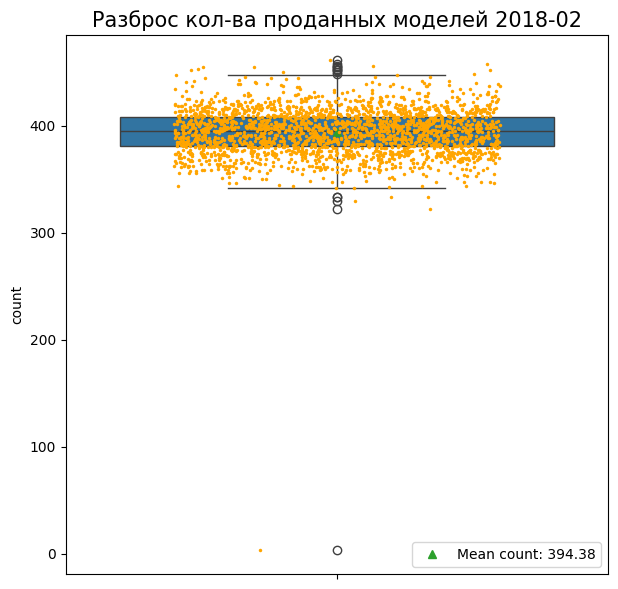

In [32]:
count_models_boxplot(tar_df)

In [33]:
# Выручка за месяц
tar_df.select(f.sum(f.col('price')).alias('revenue'))\
      .select(f.format_number('revenue', 2).alias('revenue'))\
      .show()

+-----------------+
|          revenue|
+-----------------+
|63,511,871,014.00|
+-----------------+



In [34]:
# Топ 5 покупателей за определенный месяц
tar_df.groupby('buyers_id').agg(f.sum('price').alias('revenue'))\
      .orderBy('revenue', ascending=False)\
      .select('buyers_id', f.format_number('revenue', 2).alias('revenue')).limit(5).show()

+---------+------------+
|buyers_id|     revenue|
+---------+------------+
|   440137|4,874,820.00|
|   308230|4,566,014.00|
|   162102|4,341,970.00|
|   480531|4,159,112.00|
|   633234|4,064,092.00|
+---------+------------+



In [ ]:
get_map_top_buyers(tar_df, "month_map")

### Вывод работы ф-ции get_map_top_buyers(tar_df, "month_map"):

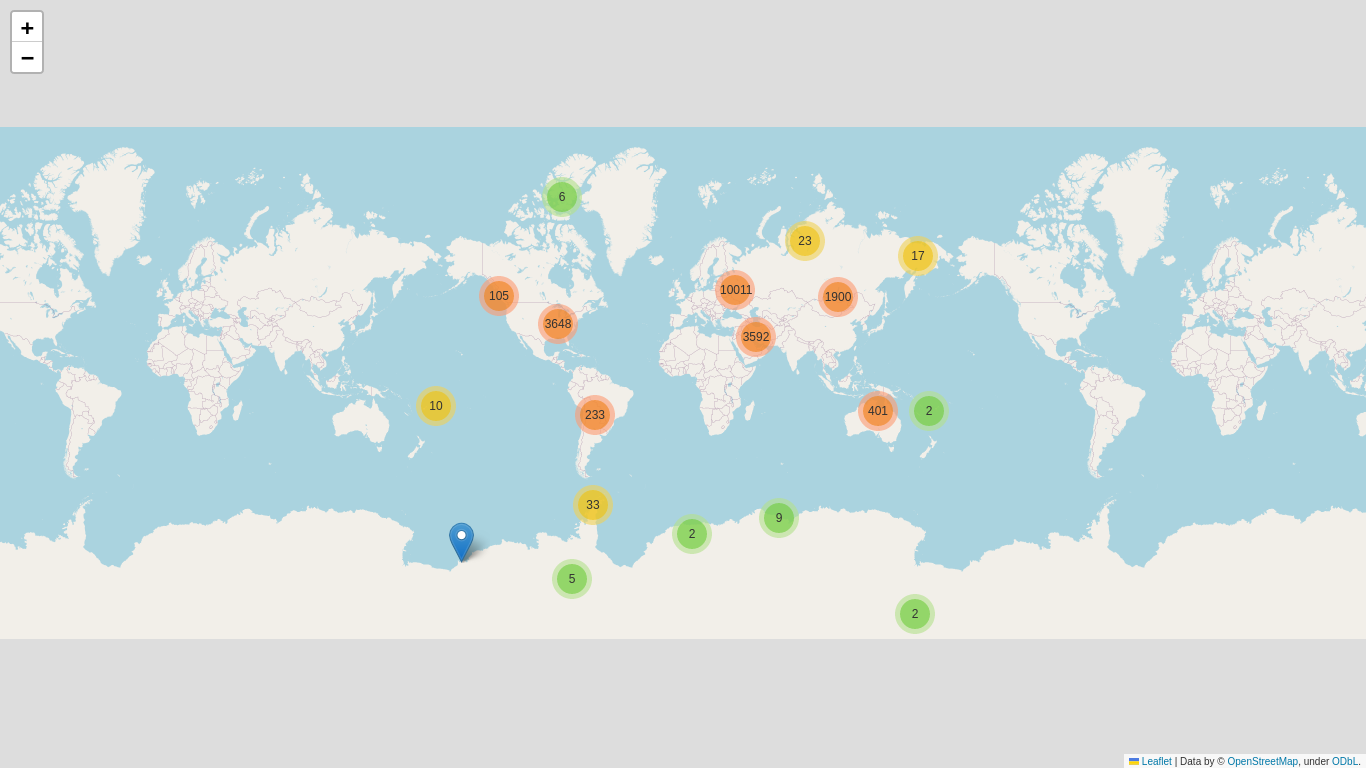

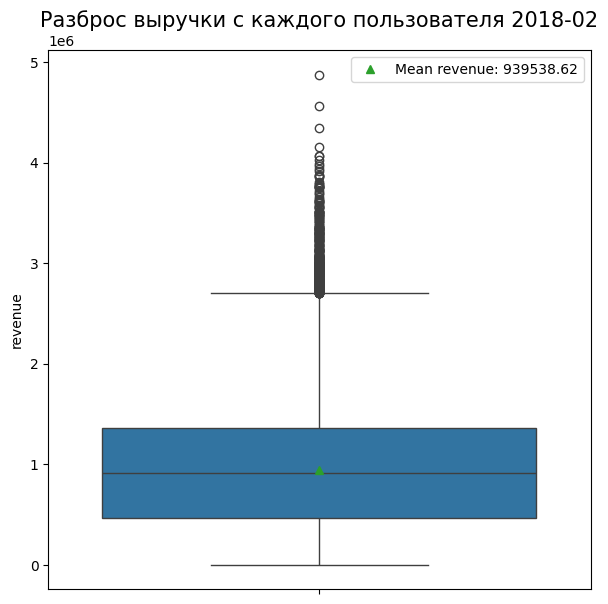

In [36]:
buyers_revenue_boxplot(tar_df)

In [37]:
# Кол-во уникальных пользователей за месяц
tar_df.select(f.format_number(f.countDistinct(f.col('buyers_id')), 2).alias("unique_users_count")).show()

+------------------+
|unique_users_count|
+------------------+
|         67,599.00|
+------------------+



## Year metrics

In [38]:
target_date = "2020"

tar_df = data.filter(f.date_format(f.col("time"), "yyyy") == target_date)

In [39]:
# Топ 5 моделей проданных за этот год
tar_df.groupby('item_id').count()\
      .join(df_prod, tar_df.item_id == df_prod.prod_id, "left")\
      .drop('prod_id').orderBy('count', ascending=False).limit(5)\
      .withColumn("concatenated_column", f.concat(f.col('brand'), f.lit(" "), f.col("model"), f.lit(" "), f.col("series"), f.lit(" "), f.col("memory")))\
      .select('item_id', 'count', 'concatenated_column', 'price').show()

+-------+-----+--------------------+--------+
|item_id|count| concatenated_column|   price|
+-------+-----+--------------------+--------+
|     22| 5383|realme c55 standa...| 20999.0|
|   1368| 5381|samsung galaxy s2...|105990.0|
|   1724| 5374|apple iphone 14 4/32|160990.0|
|    347| 5370|samsung galaxy s2...| 89999.0|
|   1215| 5366|apple iphone 14 4/32|188990.0|
+-------+-----+--------------------+--------+



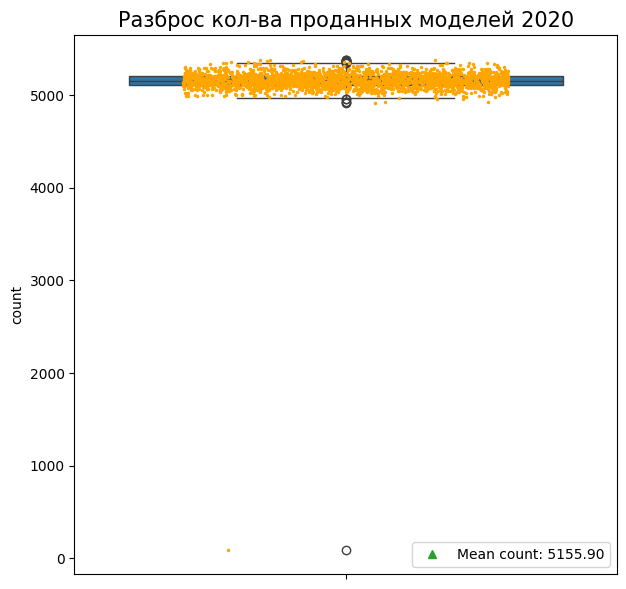

In [40]:
count_models_boxplot(tar_df)

In [41]:
# Выручка за год
tar_df.select(f.sum(f.col('price')).alias('revenue'))\
      .select(f.format_number('revenue', 2).alias('revenue'))\
      .show()

+------------------+
|           revenue|
+------------------+
|829,979,202,185.00|
+------------------+



In [42]:
# Топ 5 покупателей за определенный год
tar_df.groupby('buyers_id').agg(f.sum('price').alias('revenue'))\
      .orderBy('revenue', ascending=False)\
      .select('buyers_id', f.format_number('revenue', 2).alias('revenue')).limit(5).show()

+---------+-------------+
|buyers_id|      revenue|
+---------+-------------+
|   807967|10,506,215.00|
|   312198| 9,843,248.00|
|   812434| 9,381,358.00|
|   114315| 9,011,189.00|
|   685338| 8,887,414.00|
+---------+-------------+



In [ ]:
get_map_top_buyers(tar_df, "year_map")

### Вывод работы ф-ции get_map_top_buyers(tar_df, "year_map"):

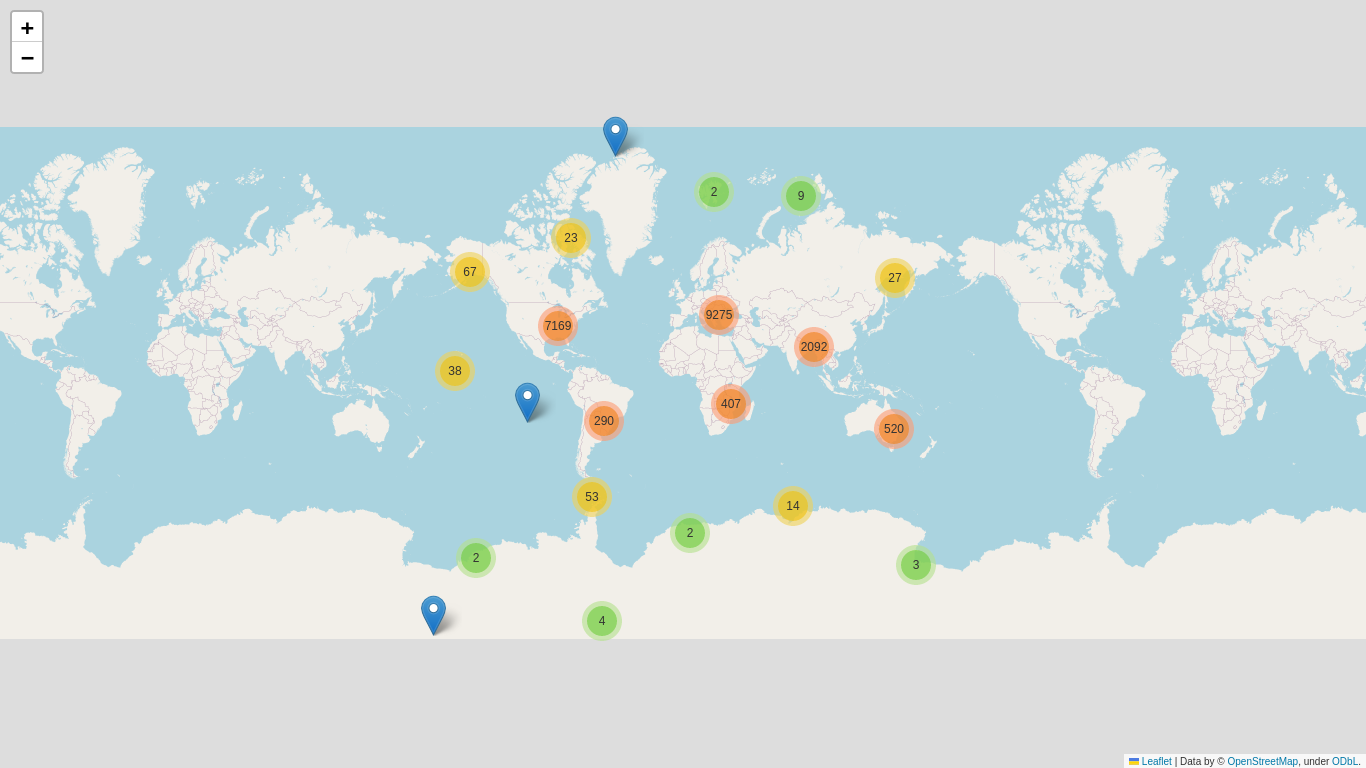

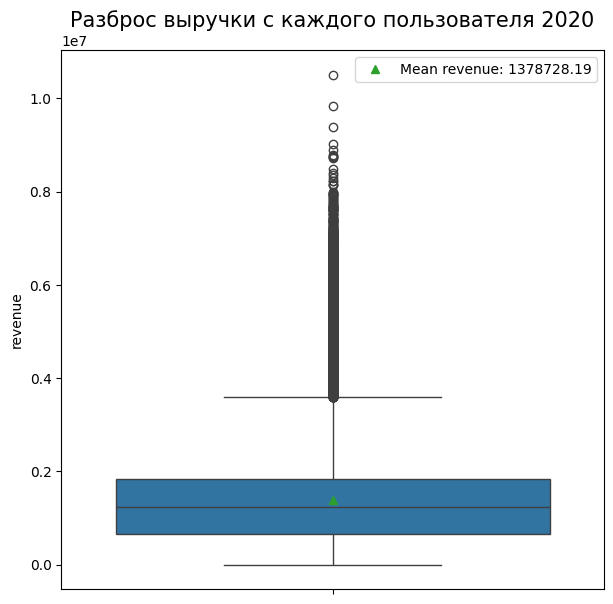

In [44]:
buyers_revenue_boxplot(tar_df)

In [45]:
# Кол-во уникальных пользователей за год
tar_df.select(f.format_number(f.countDistinct(f.col('buyers_id')), 2).alias("unique_users_count")).show()

+------------------+
|unique_users_count|
+------------------+
|        601,989.00|
+------------------+



## Пример использования reverse geocoder

In [46]:
import geocoder

In [47]:
@udf(returnType=StringType())
def reverse_geocode_country(lat, lon):
    g = geocoder.osm([lat, lon], method='reverse').json
    if g:
        return g.get('country')
    else:
        return 'no country'

In [48]:
@udf(returnType=StringType())
def reverse_geocode_address(lat, lon):
    g = geocoder.osm([lat, lon], method='reverse').json
    if g:
        return g.get('address')
    else:
        return 'no address'

In [49]:
df_buy.withColumn("country", reverse_geocode_country(df_buy.geo_lat, df_buy.geo_lon)) \
      .withColumn("address", reverse_geocode_address(df_buy.geo_lat, df_buy.geo_lon)).show()

+---+-----------+----------+--------------+--------------------+--------------------+--------------------+
| id|    geo_lon|   geo_lat|         place|              region|             country|             address|
+---+-----------+----------+--------------+--------------------+--------------------+--------------------+
|  1|  44.579166| 39.143055|          Maku| Azarbayjan-e Gharbi|               ایران|محمد آقا علیا, ده...|
|  2|-118.666115|  37.13889|   West Bishop|          California|       United States|Fresno County, Ca...|
|  3|    -5.9362|   14.8027|        Sokolo|               Segou|                Mali|Tomoni 2, Cercle ...|
|  4|  39.783333|-5.1666665|   Chake Chake|         Pemba South|            Tanzania|Ziwani, Chake-Cha...|
|  5|  20.616667|  8.566667|         Ndele|   Bamingui-Bangoran|        Centrafrique|Lokotoumala, Bami...|
|  6| -79.711945| 39.856945|       Hopwood|        Pennsylvania|       United States|375, Hopwood Fair...|
|  7|  -77.25806| 35.824444| Roberson

---